In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.2 MB/s eta 0:00:00


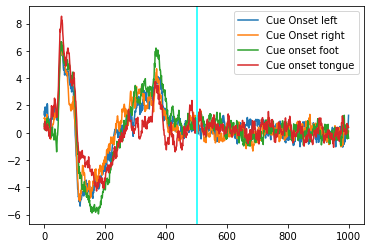

In [ ]:
!pip install -U tensorflow-addons
from keras.layers.reshaping.flatten import Flatten
from keras.layers.core.activation import Activation
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

X_test = np.load("/content/drive/MyDrive/final/X_test.npy")
y_test = np.load("/content/drive/MyDrive/final/y_test.npy")
person_train_valid = np.load("/content/drive/MyDrive/final/person_train_valid.npy")
X_train_valid = np.load("/content/drive/MyDrive/final/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/final/y_train_valid.npy")
person_test = np.load("/content/drive/MyDrive/final/person_test.npy")

# X_test = torch.tensor(X_test)
# y_test = torch.tensor(y_test)
# person_train_valid = torch.tensor(person_train_valid)
# X_train_valid = torch.tensor(X_train_valid)
# y_train_valid = torch.tensor(y_train_valid)
# person_test = torch.tensor(person_test)
y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [ ]:
def data_prep(X,y,sub_sample,average,noise,period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]

    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_reshape = X.reshape(X.shape[0], X.shape[1], -1, sub_sample)
    X_max = np.max(X_reshape, axis=3)
    
    total_X = X_max
    total_y = y
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    if noise:
      X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    return total_X,total_y
        
def data_finalize(period, total_number, takeout_sample, y_test=y_test): 
    ind_valid = np.random.choice(total_number, takeout_sample, replace=False)  # get 375 out of 2115 samples and no repetitation
    ind_train = np.array(list(set(range(total_number)).difference(set(ind_valid)))) # a set(unordered) different with another set, set = set1 - set2

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period=period)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period=period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period=period)

    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)

    return x_train, x_valid, x_test, y_train, y_valid, y_test

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, channels):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.channels = channels

    def call(self, images):
        num_samples = tf.shape(images)[0]
        
        # Create a function to apply patchify_image with the given patch_size and channels
        
        patchify_image(image, patch_size, channels)
        patches = tf.map_fn(process_image, images, fn_output_signature=tf.TensorSpec((None, None), tf.float32))
        return patches

In [ ]:
def create_mlp(dim, hidden_dim, dropout=0.1):
    return tf.keras.Sequential([
        layers.Dense(hidden_dim, activation=tf.nn.gelu),
        layers.Dropout(dropout),
        layers.Dense(dim),
        layers.Dropout(dropout)
    ])


def patchify_image(image, patch_size, channels):
    h, w = image.shape[0], image.shape[1]
    patches = tf.image.extract_patches(images=tf.expand_dims(image, 0),
                                       sizes=[1, patch_size, patch_size, 1],
                                       strides=[1, patch_size, patch_size, 1],
                                       rates=[1, 1, 1, 1],
                                       padding='VALID')
    return tf.reshape(patches, (-1, patch_size * patch_size * channels))


class Patches(layers.Layer):
    def __init__(self, patch_size, channels):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.channels = channels

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.map_fn(lambda img: patchify_image(img, self.patch_size, self.channels), images, fn_output_signature=tf.TensorSpec((None, None), tf.float32))
        return patches


class ViTModel(tf.keras.Model):
    def __init__(self, num_classes, height, width, patch_size, num_layers, num_heads, hidden_dim, mlp_dim, channels, dropout=0.1):
        super(ViTModel, self).__init__()
        self.num_layers = num_layers
        num_patches_h = height // patch_size
        num_patches_w = 1
        num_patches = num_patches_h * num_patches_w
        patch_dim = channels * patch_size ** 2

        self.patch_layer = Patches(patch_size, channels)
        self.position_embeddings = layers.Embedding(input_dim=num_patches, output_dim=patch_dim)
        self.class_token = tf.Variable(initial_value=tf.zeros(shape=(1, 1, patch_dim)), trainable=True)

        self.transformer_layers = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=patch_dim, dropout=dropout)
            for _ in range(num_layers)
        ]
        self.norm_layers = [layers.LayerNormalization(epsilon=1e-6) for _ in range(num_layers)]
        self.mlp_layers = [create_mlp(dim=patch_dim, hidden_dim=mlp_dim, dropout=dropout) for _ in range(num_layers)]

        self.pooling = layers.GlobalAveragePooling1D()
        self.classification = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        patches = self.patch_layer(inputs)
        position_embeddings = self.position_embeddings(tf.range(0, tf.shape(patches)[1]))
        x = patches + position_embeddings
        class_tokens = tf.broadcast_to(self.class_token, [batch_size, 1, self.class_token.shape[-1]])
        x = tf.concat([class_tokens, x], axis=1)

        for i in range(self.num_layers):
            attention_output = self.transformer_layers[i](x, x)
            x = x + attention_output
            x = self.norm_layers[i](x)
            mlp_output = self.mlp_layers[i](x)
            x = x + mlp_output

        x = self.pooling(x)
        x = self.classification(x)
        return x


def create_vit_classifier(num_classes, height, width=1, patch_size=1, num_layers=3, num_heads=8, hidden_dim=200, mlp_dim=300, channels=22, dropout=0.5):
    return ViTModel(num_classes=num_classes, height=height, width=width, patch_size=patch_size, num_layers=num_layers, num_heads=num_heads, hidden_dim=hidden_dim, mlp_dim=mlp_dim, channels=channels, dropout=dropout)


In [ ]:
# get subject 1 data for training and validation set
person_train_valid = person_train_valid.flatten()
X_train_valid=X_train_valid[np.where(person_train_valid==0)]
y_train_valid=y_train_valid[np.where(person_train_valid==0)]

x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=237, takeout_sample=42, period=1000, y_test=y_test)

# get subject 1 data for test set
person_test=person_test.flatten()
X_test_sub1 = x_test[np.where(person_test==0)]
y_test_sub1 = y_test[np.where(person_test==0)]

In [ ]:
num_classes = 4  
height = x_train.shape[1]
width = 1
channel = 22
input_shape = (height, width, channel)
# Create the ViT model
vit_classifier = create_vit_classifier(num_classes, height=height, width=width)

# Compile the model
vit_classifier.build(input_shape=(None, *input_shape))
vit_classifier.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
epochs = 50  # Set the number of epochs you want to train for
batch_size = 32  # Set the batch size for training

history = vit_classifier.fit(x_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=True,
                             validation_data=(x_valid, y_valid))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/50
25/25 [==============================] - 14s 278ms/step - loss: 1.3661 - accuracy: 0.3192 - val_loss: 1.5289 - val_accuracy: 0.2440
Epoch 2/50
25/25 [==============================] - 5s 212ms/step - loss: 1.2899 - accuracy: 0.4038 - val_loss: 1.5955 - val_accuracy: 0.2857
Epoch 3/50
25/25 [==============================] - 5s 214ms/step - loss: 1.1851 - accuracy: 0.4936 - val_loss: 2.0767 - val_accuracy: 0.2798
Epoch 4/50
25/25 [==============================] - 4s 179ms/step - loss: 1.1794 - accuracy: 0.4654 - val_loss: 1.5901 - val_accuracy: 0.3452
Epoch 5/50
25/25 [==============================] - 5s 190ms/step - loss: 0.9937 - accuracy: 0.5897 - val_loss: 1.7021 - val_accuracy: 0.3155
Epoch 6/50
25/25 [==============================] - 5s 193ms/step - loss: 0.9978 - accuracy: 0.5615 - val_loss: 1.6252 - val_accuracy: 0.3631
Epoch 7/50
25/25 [==============================] - 5s 190ms/step - loss: 0.8611 - accuracy: 0.6449 - val_loss: 1.7605 - val_accuracy: 0.3869
Epoch

In [ ]:
transformer_score = vit_classifier.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the basic CNN model:',transformer_score[1])

Test accuracy of the basic CNN model: 0.25999999046325684


In [ ]:
X_test = np.load("/content/drive/MyDrive/final/X_test.npy")
y_test = np.load("/content/drive/MyDrive/final/y_test.npy")
X_train_valid = np.load("/content/drive/MyDrive/final/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/final/y_train_valid.npy")
y_train_valid -= 769
y_test -= 769
x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=1000, y_test=y_test)
num_classes = 4  
height = x_train.shape[1]
width = 1
channel = 22
input_shape = (height, width, channel)
# Create the ViT model
vit_classifier = create_vit_classifier(num_classes, height=height, width=width)

# Compile the model
vit_classifier.build(input_shape=(None, *input_shape))
vit_classifier.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])
epochs = 50  # Set the number of epochs you want to train for
batch_size = 32  # Set the batch size for training

history = vit_classifier.fit(x_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             verbose=True,
                             validation_data=(x_valid, y_valid))

Epoch 1/50
218/218 [==============================] - 43s 185ms/step - loss: 1.3791 - accuracy: 0.2874 - val_loss: 1.4226 - val_accuracy: 0.2493
Epoch 2/50
218/218 [==============================] - 39s 180ms/step - loss: 1.3663 - accuracy: 0.3080 - val_loss: 1.4194 - val_accuracy: 0.3093
Epoch 3/50
218/218 [==============================] - 39s 180ms/step - loss: 1.3566 - accuracy: 0.3208 - val_loss: 1.4312 - val_accuracy: 0.3073
Epoch 4/50
218/218 [==============================] - 42s 191ms/step - loss: 1.3463 - accuracy: 0.3297 - val_loss: 1.4200 - val_accuracy: 0.2873
Epoch 5/50
218/218 [==============================] - 39s 179ms/step - loss: 1.3353 - accuracy: 0.3486 - val_loss: 1.3900 - val_accuracy: 0.3127
Epoch 6/50
218/218 [==============================] - 41s 190ms/step - loss: 1.3305 - accuracy: 0.3552 - val_loss: 1.5155 - val_accuracy: 0.3233
Epoch 7/50
218/218 [==============================] - 41s 190ms/step - loss: 1.3207 - accuracy: 0.3714 - val_loss: 1.4640 - val_ac

In [ ]:
print(X_test_sub1.shape, y_test_sub1.shape)
transformer_score = vit_classifier.evaluate(X_test_sub1, y_test_sub1, verbose=0)
print('Test accuracy of the basic CNN model:',transformer_score[1])

(50, 500, 1, 22) (50, 4)
Test accuracy of the basic CNN model: 0.4399999976158142


In [ ]:
print(x_test.shape, y_test.shape)
transformer_score = vit_classifier.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the basic CNN model:',transformer_score[1])

(1772, 500, 1, 22) (1772, 4)
Test accuracy of the basic CNN model: 0.42607223987579346


In [ ]:
X_test = np.load("/content/drive/MyDrive/final/X_test.npy")
X_train_valid = np.load("/content/drive/MyDrive/final/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/final/y_train_valid.npy")
y_train_valid -= 769
short_time_train_scores = {}
short_time_test_scores = {}
for i in range(50, 650, 50):
    y_test = np.load("/content/drive/MyDrive/final/y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    num_classes = 4  
    height = x_train.shape[1]
    width = 1
    channel = 22
    input_shape = (height, width, channel)
    # Create the ViT model
    vit_classifier = create_vit_classifier(num_classes, height=height, width=width)

    # Compile the model
    vit_classifier.build(input_shape=(None, *input_shape))
    vit_classifier.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    epochs = 50  # Set the number of epochs you want to train for
    batch_size = 32  # Set the batch size for training

    history = vit_classifier.fit(x_train, y_train,
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=True,
                                 validation_data=(x_valid, y_valid))
    short_time_train_scores[str(i)] = vit_classifier.evaluate(x_train, y_train)[1]
    short_time_test_scores[str(i)] = vit_classifier.evaluate(x_test, y_test)[1]
print(short_time_train_scores)
print(short_time_test_scores)

Epoch 1/50
218/218 [==============================] - 9s 26ms/step - loss: 1.3748 - accuracy: 0.3167 - val_loss: 1.3931 - val_accuracy: 0.2987
Epoch 2/50
218/218 [==============================] - 5s 22ms/step - loss: 1.3501 - accuracy: 0.3358 - val_loss: 1.3534 - val_accuracy: 0.3173
Epoch 3/50
218/218 [==============================] - 6s 27ms/step - loss: 1.3331 - accuracy: 0.3569 - val_loss: 1.3679 - val_accuracy: 0.3027
Epoch 4/50
218/218 [==============================] - 5s 22ms/step - loss: 1.3234 - accuracy: 0.3616 - val_loss: 1.3780 - val_accuracy: 0.3160
Epoch 5/50
218/218 [==============================] - 6s 27ms/step - loss: 1.3125 - accuracy: 0.3740 - val_loss: 1.3787 - val_accuracy: 0.3127
Epoch 6/50
218/218 [==============================] - 5s 22ms/step - loss: 1.3030 - accuracy: 0.3795 - val_loss: 1.3723 - val_accuracy: 0.3213
Epoch 7/50
218/218 [==============================] - 5s 22ms/step - loss: 1.2992 - accuracy: 0.3945 - val_loss: 1.3698 - val_accuracy: 0.3393

In [ ]:
X_test = np.load("/content/drive/MyDrive/final/X_test.npy")
X_train_valid = np.load("/content/drive/MyDrive/final/X_train_valid.npy")
y_train_valid = np.load("/content/drive/MyDrive/final/y_train_valid.npy")
y_train_valid -= 769
long_time_train_scores = {}
long_time_test_scores = {}
for i in range(700, 1100, 100):
    y_test = np.load("/content/drive/MyDrive/final/y_test.npy")
    y_test -= 769
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(total_number=2115, takeout_sample=375, period=i, y_test=y_test)
    num_classes = 4  
    height = x_train.shape[1]
    width = 1
    channel = 22
    input_shape = (height, width, channel)
    # Create the ViT model
    vit_classifier = create_vit_classifier(num_classes, height=height, width=width)

    # Compile the model
    vit_classifier.build(input_shape=(None, *input_shape))
    vit_classifier.compile(optimizer=tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
    epochs = 50  # Set the number of epochs you want to train for
    batch_size = 32  # Set the batch size for training

    history = vit_classifier.fit(x_train, y_train,
                                 batch_size=batch_size,
                                 epochs=epochs,
                                 verbose=True,
                                 validation_data=(x_valid, y_valid))
    long_time_train_scores[str(i)] = vit_classifier.evaluate(x_train, y_train)[1]
    long_time_test_scores[str(i)] = vit_classifier.evaluate(x_test, y_test)[1]
print(long_time_train_scores)
print(long_time_test_scores)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/50
218/218 [==============================] - 37s 113ms/step - loss: 1.3788 - accuracy: 0.3016 - val_loss: 1.3947 - val_accuracy: 0.2947
Epoch 2/50
218/218 [==============================] - 23s 105ms/step - loss: 1.3600 - accuracy: 0.3220 - val_loss: 1.3935 - val_accuracy: 0.2880
Epoch 3/50
218/218 [==============================] - 24s 108ms/step - loss: 1.3470 - accuracy: 0.3296 - val_loss: 1.3941 - val_accuracy: 0.2847
Epoch 4/50
218/218 [==============================] - 24s 110ms/step - loss: 1.3325 - accuracy: 0.3466 - val_loss: 1.3910 - val_accuracy: 0.3180
Epoch 5/50
218/218 [==============================] - 23s 106ms/step - loss: 1.3062 - accuracy: 0.3750 - val_loss: 1.4161 - val_accuracy: 0.3113
Epoch 6/50
218/218 [==============================] - 24s 109ms/step - loss: 1.2862 - accuracy: 0.3940 - val_loss: 1.3654 - val_accuracy: 0.3580
Epoch 7/50
218/218 [==============================] - 24s 108ms/step - loss: 1.2640 - accuracy: 0.4174 - val_loss: 1.3471 - val_ac